# Experimentos Unitários

In [1]:
import sys, os, json

project_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Ajuste conforme a localização do notebook
if project_path not in sys.path:
    sys.path.insert(0, project_path)

In [2]:
import matplotlib.pyplot as plt

def plot_positions(filename="positions.dat"):
    positions = {}
    
    with open(filename, "r") as file:
        for line in file:
            if line.startswith("#") or line.strip() == "":
                continue
            parts = line.split()
            mote_id, _, x, y = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])
        
            if mote_id not in positions:
                positions[mote_id] = []
            positions[mote_id].append((x, y))
    
    plt.figure(figsize=(8, 8))
    
    for mote_id, pos in positions.items():
        x_mobile, y_mobile = zip(*pos)
        plt.plot(x_mobile, y_mobile, marker='o', linestyle='-', label=f'Mobile Node {mote_id}')
    
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Node Positions")
    plt.legend()
    plt.grid()    
    plt.axis("equal")
    plt.show()
    
def plot_positions_with_radius(filename="positions.dat", radius=10):
    positions = {}
    
    with open(filename, "r") as file:
        for line in file:
            if line.startswith("#") or line.strip() == "":
                continue
            parts = line.split()
            mote_id, _, x, y = int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])
        
            if mote_id not in positions:
                positions[mote_id] = []
            positions[mote_id].append((x, y))
    
    plt.figure(figsize=(8, 8))
        
    # Plot mobile motes
    for mote_id, pos in positions.items():
        x_mobile, y_mobile = zip(*pos)
        plt.plot(x_mobile, y_mobile, marker='o', linestyle='-', label=f'Mobile Node {mote_id}')
        if len(pos) == 1:
            for x, y in pos:
                circle = plt.Circle((x, y), radius, color='gray', linestyle='dashed', fill=False)
                plt.gca().add_patch(circle)
        
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Node Positions with Coverage Circles")
    plt.legend()
    plt.grid()
    plt.axis("equal")
    plt.show()

In [3]:
import json
import numpy as np

def evaluate_function(expression, t_values):
    """Avalia a função matemática dada como string para um conjunto de valores de t."""
    return np.array([eval(expression, {"t": t, "np": np}) for t in t_values])

def generate_positions_from_json(json_filename, output_filename="positions.dat"):
    with open(json_filename, "r") as file:
        config = json.load(file)
    
    fixed_positions = [(mote["position"][0], mote["position"][1]) for mote in config["fixedMotes"]]
    mobile_motes = config["mobileMotes"]
    
    with open(output_filename, "w") as file:
        # Escreve os motes fixos
        file.write("# Fixed positions\n")
        for i, (x, y) in enumerate(fixed_positions):
            file.write(f"{i} 0.00000000 {x:.2f} {y:.2f}\n")
        file.write("\n")
        
        # Escreve os motes móveis
        file.write("# Mobile nodes\n")
        mote_index = len(fixed_positions)
        max_steps = 0
        mobile_trajectories = []
        
        for mote in mobile_motes:
            x_expr, y_expr = mote["functionPath"]
            speed = mote["speed"]
            time_step = mote["timeStep"]
            is_round_trip = mote.get("isRoundTrip", False)
            
            t_values = np.linspace(0, 1, num=100)  # Discretização uniforme no intervalo [0,1]
            x_values = evaluate_function(x_expr, t_values)
            y_values = evaluate_function(y_expr, t_values)
            
            # Calcular a distância total percorrida
            distances = np.sqrt(np.diff(x_values)**2 + np.diff(y_values)**2)
            total_distance = np.sum(distances)
            duration = total_distance / speed
            steps = max(1, int(duration / time_step))  # Garante pelo menos um passo
            max_steps = max(max_steps, steps)
            
            if steps > 1:
                x_interp = np.interp(np.linspace(0, 1, steps), t_values, x_values)
                y_interp = np.interp(np.linspace(0, 1, steps), t_values, y_values)
            else:
                x_interp = np.array([x_values[0]])
                y_interp = np.array([y_values[0]])
            
            if is_round_trip:
                x_full = np.concatenate((x_interp, x_interp[::-1]))
                y_full = np.concatenate((y_interp, y_interp[::-1]))
            else:
                x_full = x_interp
                y_full = y_interp
            
            mobile_trajectories.append((mote_index, x_full, y_full, time_step))
            mote_index += 1
        
        for step in range(2 * max_steps):
            for mote_id, x_full, y_full, time_step in mobile_trajectories:
                if step < len(x_full):
                    file.write(f"{mote_id} {step * time_step:.8f} {x_full[step]:.2f} {y_full[step]:.2f}\n")
            file.write("\n")
    
    print(f"File {output_filename} generated successfully!")

path_segments [['100 * np.cos(2 * np.pi * t)', '40 * np.sin(2 * np.pi * t)']]


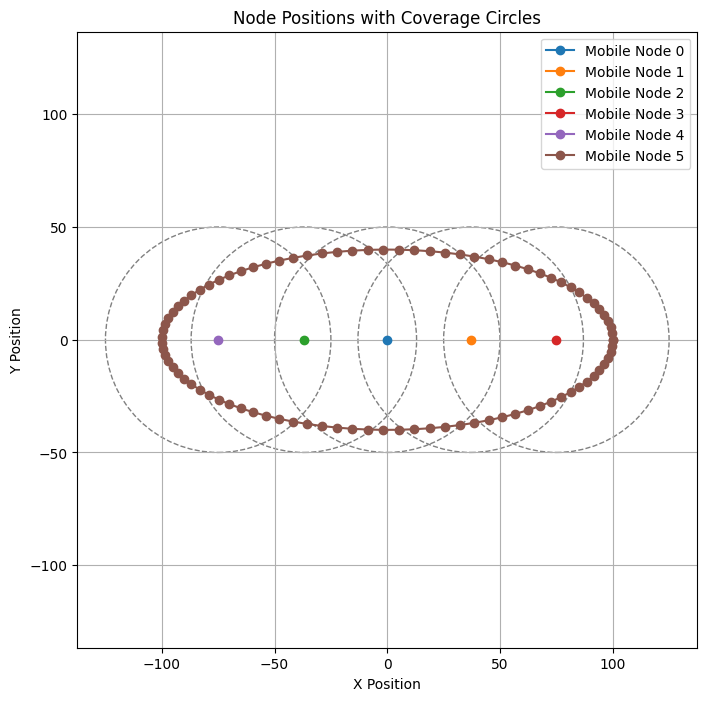

In [4]:
from pylib import parse_json_pos

output_pos = "./output/positions.dat"
with open("./json/mobile1.json", 'r', encoding='utf-8') as f:
    base_json = json.load(f)
    
parse_json_pos.generate_positions_from_json(base_json, output_pos)
plot_positions_with_radius(output_pos, radius=50)

Em uma simulação com a interface do Cooja verificamos que o tempo de um ciclo do caminho dado é de aproxidamente 90 segundos. A seguir computamos o perímetro da elipse, obtendo apróximadamente 460.2 m. Assim a velocidade do mote móviel é:
$$
v = \frac{460.2(m)}{90(s)}=5.11(m/s)
$$

In [5]:
from scipy.special import ellipe

def perimetro_exato(a, b):
    """
    Calcula o perímetro de uma elipse usando a integral elíptica completa de segunda espécie.
    """
    e_sq = 1 - (b ** 2) / (a ** 2)
    P = 4 * a * ellipe(e_sq)
    return P

# Exemplo de uso
a = 100  # Semi-eixo maior
b = 40   # Semi-eixo menor

p = perimetro_exato(a, b)

print(f"Semi-eixos: a={a}, b={b}")
print(f"Perímetro Elipse: {p:.4f}")
print(f"Velocidade do Mote:{p / 90:.2f} m/s")

Semi-eixos: a=100, b=40
Perímetro Elipse: 460.2623
Velocidade do Mote:5.11 m/s


In [6]:
import json

def overwrite_json_input_file(
    embed_file: str,
    region: tuple[float, float, float, float],
    radius: float,
    interference_radius: float
) -> dict:
    """
    Gera um dicionário no formato esperado para o arquivo de entrada JSON da simulação.

    Parameters:
    - points: lista de tuplas (x, y) representando posições dos motes
    - region: tupla (x_min, y_min, x_max, y_max) definindo a região da simulação
    - radius: raio de comunicação dos motes
    - interference_radius: raio de interferência dos motes

    Returns:
    - Um dicionário com a estrutura especificada para o modelo de simulação
    """

    # Ler o JSON a ser embutido
    with open(embed_file, 'r', encoding='utf-8') as f:
        embed_json_data = json.load(f)

    simulation_model = {
        "simulationModel": {
            "name": "single-experiment-sim-lab",
            "duration": 60,
            "radiusOfReach": radius,
            "radiusOfInter": interference_radius,
            "region": list(region),
            "simulationElements": embed_json_data
        }
    }

    return simulation_model


## Lista todos experimentos prédefinidos

## Utilize esta parte para gerar o próximo experimento a ser executado

In [7]:

content = overwrite_json_input_file(
        embed_file="./json/mobile1.json", 
        region=[-200,-200,200,200],
        radius=50,
        interference_radius=60)

with open("data/inputExample.json", "w") as f:
    json.dump(content, f, indent=2)
 
# Executa a conversão tendo como entrada os arquivos do diretório `data` e como saída os arquivos do diretório `output`   
!py build.py


path_segments [['100 * np.cos(2 * np.pi * t)', '40 * np.sin(2 * np.pi * t)']]
File output\simulation.xml generated successfully!
